<a href="https://colab.research.google.com/github/google/evojax/blob/main/examples/notebooks/AbstractPainting01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ES CLIP in JAX - Fitting Concrete Images

This Colab notebook is [JAX](https://github.com/google/jax) implementation of **Modern Evolution Strategies for Creativity: Fitting Concrete Images and Abstract Concepts** ([paper](https://arxiv.org/abs/2109.08857), [web](https://es-clip.github.io/), [original code](https://github.com/google/brain-tokyo-workshop/tree/master/es-clip) ).  It is the **Fitting Concrete Images** part.

This notebook is designed to leverage accelerators (GPUs/TPUs) and can scale well (almost linearly) with multiple accelerators thanks to JAX, so **(better multiple) accelerators are strongly encouraged**. Although it may still runs with a CPU backend, such enviroment would be extremely slow. To leverage accelerators, you could do **one** of following setting:

- **Using Colab's TPU runtime**: From the Colab menu, choose Runtime > Change Runtime Type, then select 'TPU' in the dropdown. Depending on your  Colab subscription, you may get 1-8 TPUs.
- **Using Colab's GPU runtime**: From the Colab menu, choose Runtime > Change Runtime Type, then select 'GPU' in the dropdown. Depending on your Colab subscription, you may get one GPU with in certain models.
- **Using a local runtime with multiple GPUs**. This is more envolving and needs some tweaking. The official [instructions](https://research.google.com/colaboratory/local-runtimes.html) may be helpful.

The output of in this notebook is from a running on a local runtime with 8 NVIDIA V100 GPUs.

In [ ]:
! nvidia-smi --query-gpu=name --format=csv,noheader

Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB


## Import packages and define utilities

In [ ]:
import datetime
import functools
import pprint
import os
import sys

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

from IPython.display import clear_output
import jax
from jax import lax
from jax import numpy as jnp
import numpy as np
from PIL import Image

if 'COLAB_TPU_ADDR' in os.environ:
  from jax.tools import colab_tpu
  colab_tpu.setup_tpu()

try:
  import drawSvg
except ImportError:
  ! pip install drawSvg
  clear_output()
  import drawSvg

!pip install evojax
clear_output()

from evojax.algo.pgpe import PGPE

In [ ]:
# JAX based rendering

def quantitize(a, quant):
  return lax.cond(
    quant > 0, 
    lambda v: jnp.rint(v * quant) / quant,
    lambda v: v,
    a
  )

def put_triangle_fn(i_triangle, packed_args):
  canvas, xyv, xy0, xy1, xy2, r, g, b, a, quant = packed_args
  n_batch, h, w = canvas.shape[:3]

  xy0_triangle = lax.dynamic_slice_in_dim(xy0, i_triangle, 1, axis=1)
  xy1_triangle = lax.dynamic_slice_in_dim(xy1, i_triangle, 1, axis=1)
  xy2_triangle = lax.dynamic_slice_in_dim(xy2, i_triangle, 1, axis=1)

  cross_0 = jnp.cross((xyv - xy0_triangle), (xy1_triangle - xy0_triangle))
  cross_1 = jnp.cross((xyv - xy1_triangle), (xy2_triangle - xy1_triangle))
  cross_2 = jnp.cross((xyv - xy2_triangle), (xy0_triangle - xy2_triangle))

  in_triangle_p = jnp.logical_and(jnp.logical_and(cross_0 >= 0, cross_1 >= 0), cross_2 >= 0)
  in_triangle_n = jnp.logical_and(jnp.logical_and(cross_0 <= 0, cross_1 <= 0), cross_2 <= 0)
  in_triangle = jnp.logical_or(in_triangle_p, in_triangle_n).reshape((n_batch, h, w))
  
  region_mask_triangle = jnp.repeat(jnp.expand_dims(in_triangle, axis=-1), repeats=3, axis=-1).astype(jnp.float32)
  
  r_triangle = lax.dynamic_index_in_dim(r, i_triangle, axis=-1, keepdims=False)
  g_triangle = lax.dynamic_index_in_dim(g, i_triangle, axis=-1, keepdims=False)
  b_triangle = lax.dynamic_index_in_dim(b, i_triangle, axis=-1, keepdims=False)
  a_triangle = lax.dynamic_index_in_dim(a, i_triangle, axis=-1, keepdims=False)
  r_triangle = quantitize(r_triangle, quant)
  g_triangle = quantitize(g_triangle, quant)
  b_triangle = quantitize(b_triangle, quant)
  a_triangle = quantitize(a_triangle, quant)
  
  color_plane = jnp.expand_dims(jnp.stack([r_triangle, g_triangle, b_triangle], axis=-1), axis=[1,2])
  a_mask_triangle = jnp.expand_dims(a_triangle, axis=[1,2,3])
  next_canvas = \
    (canvas * (1.0 - region_mask_triangle)) + \
    (canvas * region_mask_triangle * (1.0 - a_mask_triangle)) + \
    (color_plane * region_mask_triangle * a_mask_triangle)
  next_canvas = quantitize(next_canvas, quant)
  next_canvas = jnp.clip(a=next_canvas, a_min=0., a_max=1.)
  canvas = next_canvas
   
  packed_args = canvas, xyv, xy0, xy1, xy2, r, g, b, a, quant
  return packed_args

def render(static_params, key, params):
  h, w, alpha_scale, n_triangle, background, quant = static_params

  n_batch = params.shape[0]
  n_feature_per_triangle = 10
  
  params = params.reshape((n_batch, n_triangle, n_feature_per_triangle))
  
  params = (params - params.min(axis=1, keepdims=True)) / \
           (params.max(axis=1, keepdims=True) - params.min(axis=1, keepdims=True))
  
  x0, y0, x1, y1, x2, y2, r, g, b, a = \
    [params[:, :, i_feature] for i_feature in range(n_feature_per_triangle)]
  
  x0, x1, x2 = x0 * (h - 1), x1 * (h - 1), x2 * (h - 1)
  y0, y1, y2 = y0 * (w - 1), y1 * (w - 1), y2 * (w - 1)
  xy0 = jnp.stack([x0, y0], axis=-1).astype(jnp.int32)
  xy1 = jnp.stack([x1, y1], axis=-1).astype(jnp.int32)
  xy2 = jnp.stack([x2, y2], axis=-1).astype(jnp.int32)
  r, g, b, a = r, g , b , a * alpha_scale

  xv, yv = jnp.meshgrid(jnp.arange(0, h), jnp.arange(0, w), indexing='ij')
  xyv = jnp.stack([xv.reshape(-1), yv.reshape(-1)], axis=-1)
  xyv = jnp.repeat(jnp.expand_dims(xyv, axis=0), repeats=n_batch, axis=0) 
  
  if background == 'noise':
    key, subkey = jax.random.split(key)
    canvas = jax.random.uniform(key=subkey, shape=(n_batch, h, w, 3), dtype=jnp.float32)
  elif background == 'black':
    canvas = jnp.zeros(shape=(n_batch, h, w, 3), dtype=jnp.float32)
  elif background == 'white':
    canvas = jnp.ones(shape=(n_batch, h, w, 3), dtype=jnp.float32)

  packed_args = canvas, xyv, xy0, xy1, xy2, r, g, b, a, quant
  packed_args = lax.fori_loop(0, n_triangle, put_triangle_fn, packed_args)
  canvas, *_ = packed_args

  return canvas
  
render = jax.jit(render, static_argnums=0)

@functools.partial(jax.jit, static_argnums=0)
def make_random_params(static_params, key):
  n_batch, n_triangle, = static_params
  n_feature_per_triangle = 10
  
  key, subkey = jax.random.split(key)
  params = jax.random.uniform(subkey, shape=(n_batch, n_triangle * n_feature_per_triangle))
  return params

In [ ]:
''' SVG render '''
def render_svg(static_params, params):
  ''' Renders params into drawSvg.Drawing objects. '''

  h, w, alpha_scale, n_triangle, background, quant = static_params
  del background # background is not used.

  n_batch = params.shape[0]
  n_feature_per_triangle = 10
  
  params = params.reshape((n_batch, n_triangle, n_feature_per_triangle))
  
  params = (params - params.min(axis=1, keepdims=True)) / \
           (params.max(axis=1, keepdims=True) - params.min(axis=1, keepdims=True))
  
  x0, y0, x1, y1, x2, y2, r, g, b, a = \
    [params[:, :, i_feature] for i_feature in range(n_feature_per_triangle)]
  
  x0, x1, x2 = x0 * (h - 1), x1 * (h - 1), x2 * (h - 1)
  y0, y1, y2 = y0 * (w - 1), y1 * (w - 1), y2 * (w - 1)
  xy0 = jnp.stack([x0, y0], axis=-1).astype(jnp.int32)
  xy1 = jnp.stack([x1, y1], axis=-1).astype(jnp.int32)
  xy2 = jnp.stack([x2, y2], axis=-1).astype(jnp.int32)
  r, g, b, a = r, g , b , a * alpha_scale


  ''' 
      Cordinate system we used in JAX:

        0    y  w-1
      0 +-------+
        |
        |
      x |    * (x, y) <- order is h, w
    h-1 +
      

      Cordinate system in drawSvg:

    h-1 +
      b |    * (a, b) <- order is w, h
        |     
      0 +------+
        0    a w-1
  '''

  ds = [
    drawSvg.Drawing(w, h, displayInline=True)
    for _ in range(n_batch)
  ]

  for i in range(n_batch):
    for j in range(n_triangle):
      a0 = int(y0[i, j])
      b0 = (h - 1) - int(x0[i, j])
      a1 = int(y1[i, j])
      b1 = (h - 1) - int(x1[i, j])
      a2 = int(y2[i, j])
      b2 = (h - 1) - int(x2[i, j])
      fill = f'#'\
             f'{int(r[i, j] * 255):02x}' \
             f'{int(g[i, j] * 255):02x}' \
             f'{int(b[i, j] * 255):02x}'
      fill_opacity = float(a[i, j])
      ds[i].append(
        drawSvg.Lines(
          a0, b0, a1, b1, a2, b2, 
          close=True, fill=fill, fill_opacity=fill_opacity,
        )
      )
  return ds


In [ ]:
'''Other Utilities.'''

def canvas_to_imgs(canvas, n_batch=None):
  canvas = np.array(canvas)
  if n_batch is None:
    n_batch = canvas.shape[0]
  arr_imgs = np.array(np.clip((canvas * 255.), 0., 255.).astype(jnp.uint8))
  imgs = [Image.fromarray(arr_imgs[i_batch]) for i_batch in range(n_batch)]
  return imgs

def display_imgs(imgs):
  for img in imgs:
    display(img)

def add_batch_dim(a, size=1):
  a = jnp.expand_dims(a, axis=0)
  a = jnp.repeat(a, repeats=size, axis=0)
  return a

def pack(data):
  n_batch, n_feature = data.shape
  n_xla = jax.device_count()
  n_padding = 0 if (n_batch % n_xla == 0) else (n_xla - n_batch % n_xla)
  if n_padding > 0:
    data = jnp.concatenate([data] + [data[0:1]] * n_padding)
  data = jnp.reshape(data, (n_xla, -1, n_feature))
  return data, n_batch

def unpack(data, n_batch):
  data = data.reshape( (-1,) + data.shape[2:])
  data = data[:n_batch]
  return data

def split_pkey(key):
  n_xla = jax.device_count()
  return jax.random.split(key, n_xla)

! wget -O monalisa.png https://es-clip.github.io/assets/produced/es-bitmap-target-monalisa.png
! wget -O darwin.png https://es-clip.github.io/assets/produced/es-bitmap-target-darwin.png

clear_output()

## Setting Parameters

In [ ]:
# @title Basic Parameters
# @markdown Here are baic parameters that should be set.

# @markdown **image_filename** is the filename of images. 
# @markdown Here we prepared two images, `monalisa.png` and `darwin.png` for example.
# @markdown You can optionally upload your own file in Left Panel -> Files or
# @markdown following [instructions](https://colab.research.google.com/notebooks/io.ipynb).

image_filename = 'monalisa.png' # @param {type:"string"}
# @markdown **height** and **width** define the size of canvas.
height = 200 # @param {type:"integer"}
width = 200 # @param {type:"integer"}
# @markdown **n_triangle** specifies number of triangles.
n_triangle =  50# @param {type:"integer"}
# @markdown **seed** is the random seed.
seed = 1234 # @param {type:"number"}


In [ ]:
# @title Advanced Parameters
# @markdown Here are advances parameters that affects the fine-grained behaviors.


# @markdown **n_iterations** is the number of iterations in Evolution Strategy.
n_iterations = 10000 # @param {type:"number"}
# @markdown For every **report_interval** iterations, reports are made and images are saved.
report_interval =  100# @param {type:"number"}
# @markdown If **use_multiple_accelerators** is true (default), it will try to use multiple accelerators,
# @markdown which is useful for running on multiple TPUs/GPUs.
use_multiple_accelerators =  True #@param ["False", "True"] {type:"raw"}
# @markdown **alpha_scale** specifies the maximum alpha for each triangle.
alpha_scale = 0.5 # @param {type:"number"}
# @markdown **n_population** specifies the population size in Evolution Strategy.
n_population = 256 # @param {type:"number"}
# @markdown **n_rollouts** specifies the number of rollouts for augmentation.
n_rollouts = 4 # @param {type:"number"}
# @markdown **quant** specifies the quantization of RGBA values after painting each triangle. 
# @markdown If 0, no quantization is conducted.
quant =  0# @param {type:"number"}

# Below are derived parameters
n_feature_per_triangle = 10
n_feature = n_triangle * n_feature_per_triangle

## Define helper routines and variables

In [ ]:
img = Image.open(image_filename).resize((width, height), Image.LANCZOS)

devices = jax.local_devices()
target = jnp.array(img)[...,:3].astype(jnp.float32) / 255.0
target_p = jax.device_put_replicated(target, devices)

In [ ]:
@jax.jit
def render_and_compute_fitnesses(solutions, target, key):
  global n_rollouts, \
    height, width, alpha_scale, n_triangle, quant, \
    image_fn \
  
  # paint
  params = solutions
  background = 'white'
  static_params = (height, width, alpha_scale, n_triangle, background, quant)
  key, subkey = jax.random.split(key)
  params = jnp.repeat(params, n_rollouts, axis=0)
  canvas = render(static_params, subkey, params)

  fitnesses = jnp.square(canvas - jnp.expand_dims(target, axis=0)).mean(axis=[1,2,3]).\
              reshape((-1, n_rollouts)).mean(axis=-1)
  
  fitnesses = 1.0 - fitnesses # pgpe *maximizes*
  return fitnesses


render_and_compute_fitnesses_p = jax.pmap(render_and_compute_fitnesses)

def call_render_and_compute_fitnesses(solutions, key):
  global target
  return render_and_compute_fitnesses(solutions, target, key)

def call_render_and_compute_fitnesses_p(solutions, key):
  global target_emb_p
  solutions_p, n_batch = pack(solutions)
  key, subkey = jax.random.split(key)
  subkey_p = jax.random.split(subkey, jax.device_count())
  fitnesses_p = render_and_compute_fitnesses_p(solutions_p, target_p, subkey_p)
  fitnesses = unpack(fitnesses_p, n_batch)
  return fitnesses

def call_render_svg(solutions):
  static_params = (height, width, alpha_scale, n_triangle, None, quant)
  svg_ds = render_svg(static_params, solutions)
  return svg_ds

In [ ]:
def main_loop():
  key = jax.random.PRNGKey(seed)

  print('Target Image:')
  display(img)

  solver = PGPE(
    pop_size=n_population,
    param_size=n_feature,
    optimizer='clipup',
    optimizer_config={'max_speed': 0.15},
  )
  start_time = datetime.datetime.now()

  for iter_ in range(1, 1 + n_iterations):
    solutions = solver.ask()

    key, subkey = jax.random.split(key)
    if use_multiple_accelerators:
      fitnesses = call_render_and_compute_fitnesses_p(solutions, subkey)
    else:
      fitnesses = call_render_and_compute_fitnesses(solutions, subkey)

    solver.tell(fitnesses)

    if iter_ % report_interval == 0 or iter_ == 1 or iter_ == n_iterations:
      best_solutions = jnp.expand_dims(solver.best_params, axis=0)
      key, subkey = jax.random.split(key)
      best_fitnesses = call_render_and_compute_fitnesses(best_solutions, subkey)
      now_time = datetime.datetime.now()
      print(f'[{now_time - start_time}] Iteration {iter_:8}  ---  best_fitnesses {best_fitnesses}')

      background = 'white'
      params = best_solutions
      key, subkey = jax.random.split(key)
      canvas = render((height, width, alpha_scale, n_triangle, background, quant), subkey, params)
      pil_imgs = canvas_to_imgs(canvas)
      svg_imgs = call_render_svg(best_solutions)

      print(f'\t\t best canvas saved to `best_canvas.png` and `best_canvas.svg`')
      pil_imgs[0].save('best_canvas.png')
      svg_imgs[0].saveSvg('best_canvas.svg')

      display_imgs(pil_imgs)

## Run it.

Note the output containts fitnesses and current best canvas, which is saved 
and can be downloaded (see [instructions](https://colab.research.google.com/notebooks/io.ipynb) for more info)

Target Image:


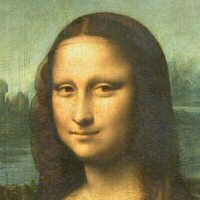

[0:00:02.373150] Iteration        1  ---  best_fitnesses [0.77476954]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


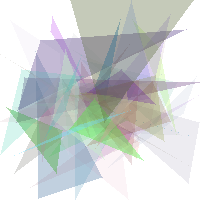

[0:00:06.461044] Iteration      100  ---  best_fitnesses [0.9751649]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


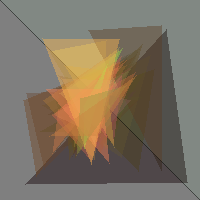

[0:00:09.244171] Iteration      200  ---  best_fitnesses [0.98174053]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


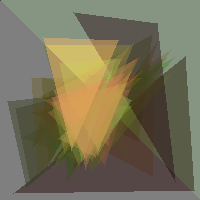

[0:00:12.021247] Iteration      300  ---  best_fitnesses [0.9845578]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


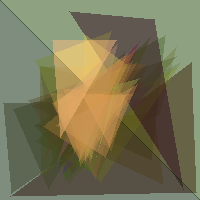

[0:00:14.806451] Iteration      400  ---  best_fitnesses [0.9860243]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


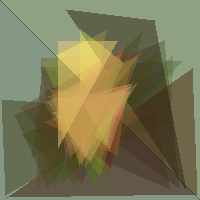

[0:00:17.585697] Iteration      500  ---  best_fitnesses [0.9848078]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


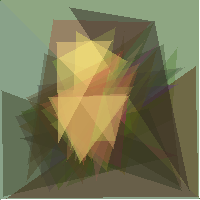

[0:00:20.381414] Iteration      600  ---  best_fitnesses [0.98864734]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


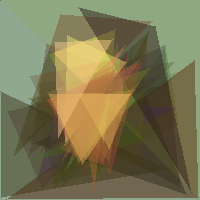

[0:00:23.216067] Iteration      700  ---  best_fitnesses [0.9893179]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


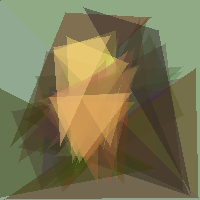

[0:00:26.045884] Iteration      800  ---  best_fitnesses [0.98984045]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


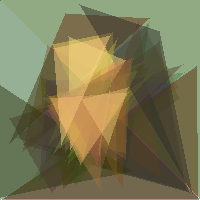

[0:00:28.886454] Iteration      900  ---  best_fitnesses [0.990203]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


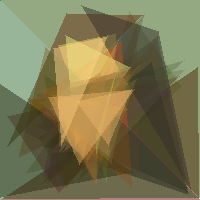

[0:00:31.697348] Iteration     1000  ---  best_fitnesses [0.9905851]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


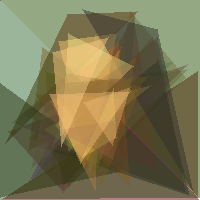

[0:00:34.470454] Iteration     1100  ---  best_fitnesses [0.9911111]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


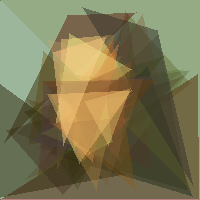

[0:00:37.271516] Iteration     1200  ---  best_fitnesses [0.99149525]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


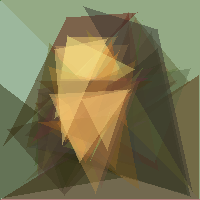

[0:00:40.031470] Iteration     1300  ---  best_fitnesses [0.9919003]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


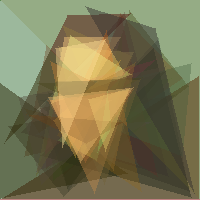

[0:00:42.803428] Iteration     1400  ---  best_fitnesses [0.99224234]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


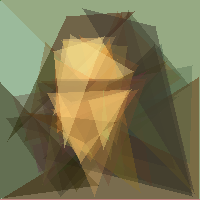

[0:00:45.575226] Iteration     1500  ---  best_fitnesses [0.9927158]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


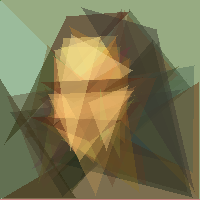

[0:00:48.337655] Iteration     1600  ---  best_fitnesses [0.9917837]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


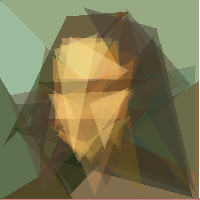

[0:00:51.122606] Iteration     1700  ---  best_fitnesses [0.9932211]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


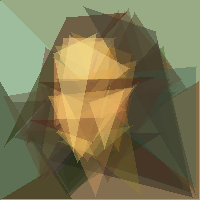

[0:00:53.912978] Iteration     1800  ---  best_fitnesses [0.9934625]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


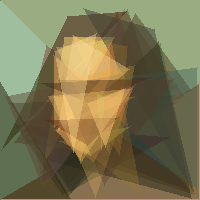

[0:00:56.688219] Iteration     1900  ---  best_fitnesses [0.99361295]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


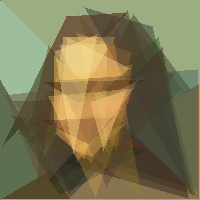

[0:00:59.484258] Iteration     2000  ---  best_fitnesses [0.99394804]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


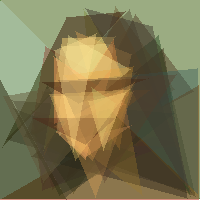

[0:01:02.261971] Iteration     2100  ---  best_fitnesses [0.9942055]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


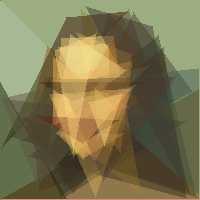

[0:01:05.025108] Iteration     2200  ---  best_fitnesses [0.9944203]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


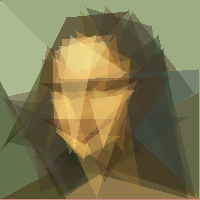

[0:01:07.785299] Iteration     2300  ---  best_fitnesses [0.9945424]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


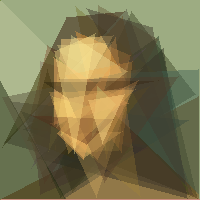

[0:01:10.554054] Iteration     2400  ---  best_fitnesses [0.99467224]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


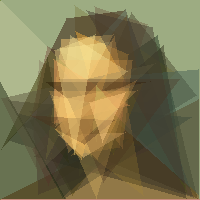

[0:01:13.354744] Iteration     2500  ---  best_fitnesses [0.9947417]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


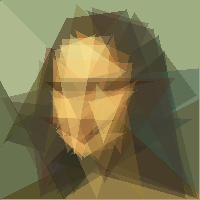

[0:01:16.127407] Iteration     2600  ---  best_fitnesses [0.99479055]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


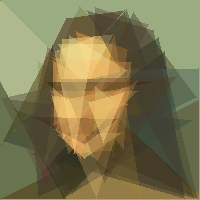

[0:01:18.930857] Iteration     2700  ---  best_fitnesses [0.99484277]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


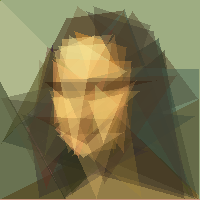

[0:01:21.730430] Iteration     2800  ---  best_fitnesses [0.9949085]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


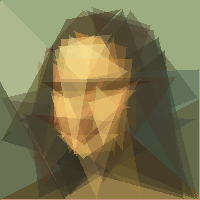

[0:01:24.489508] Iteration     2900  ---  best_fitnesses [0.99499774]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


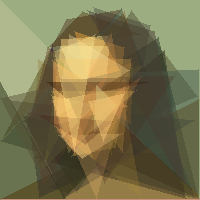

[0:01:27.302617] Iteration     3000  ---  best_fitnesses [0.9950795]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


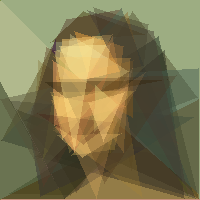

[0:01:30.102250] Iteration     3100  ---  best_fitnesses [0.99510926]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


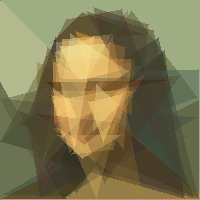

[0:01:32.877285] Iteration     3200  ---  best_fitnesses [0.9951311]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


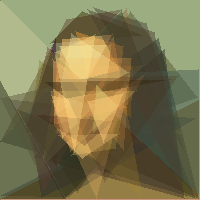

[0:01:35.667353] Iteration     3300  ---  best_fitnesses [0.99516934]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


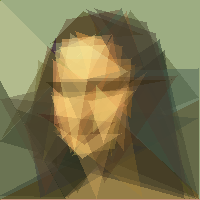

[0:01:38.445491] Iteration     3400  ---  best_fitnesses [0.99517345]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


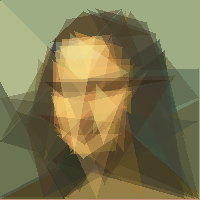

[0:01:41.221902] Iteration     3500  ---  best_fitnesses [0.9952067]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


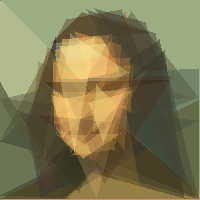

[0:01:43.997554] Iteration     3600  ---  best_fitnesses [0.99522597]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


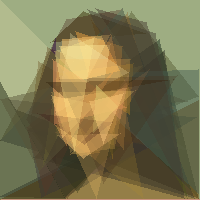

[0:01:46.755334] Iteration     3700  ---  best_fitnesses [0.9952343]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


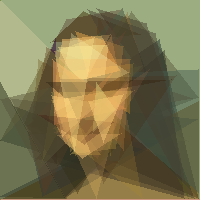

[0:01:49.538018] Iteration     3800  ---  best_fitnesses [0.99525577]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


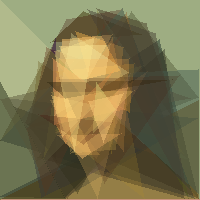

[0:01:52.303550] Iteration     3900  ---  best_fitnesses [0.99525595]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


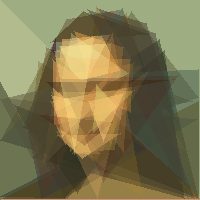

[0:01:55.111782] Iteration     4000  ---  best_fitnesses [0.9952704]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


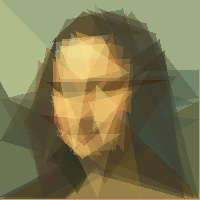

[0:01:57.921347] Iteration     4100  ---  best_fitnesses [0.99528]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


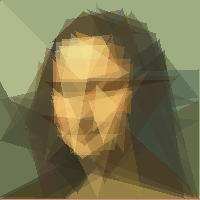

[0:02:00.713649] Iteration     4200  ---  best_fitnesses [0.9952885]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


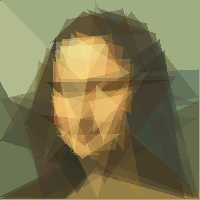

[0:02:03.472535] Iteration     4300  ---  best_fitnesses [0.9952974]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


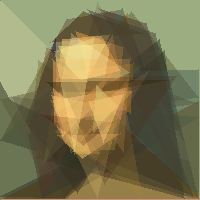

[0:02:06.275458] Iteration     4400  ---  best_fitnesses [0.99530417]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


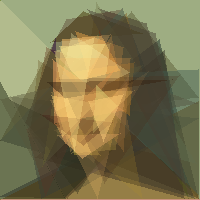

[0:02:09.054016] Iteration     4500  ---  best_fitnesses [0.9953096]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


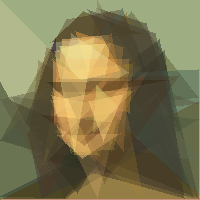

[0:02:11.821574] Iteration     4600  ---  best_fitnesses [0.99531466]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


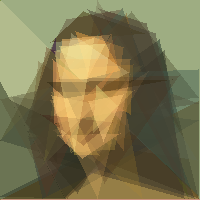

[0:02:14.589240] Iteration     4700  ---  best_fitnesses [0.99531555]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


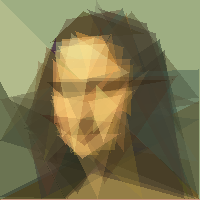

[0:02:17.377998] Iteration     4800  ---  best_fitnesses [0.995316]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


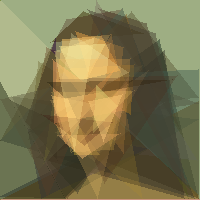

[0:02:20.168318] Iteration     4900  ---  best_fitnesses [0.99531865]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


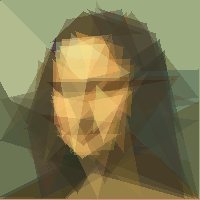

[0:02:22.927673] Iteration     5000  ---  best_fitnesses [0.99532455]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


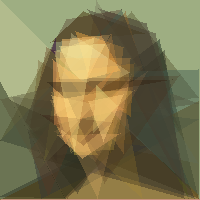

[0:02:25.722704] Iteration     5100  ---  best_fitnesses [0.9953229]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


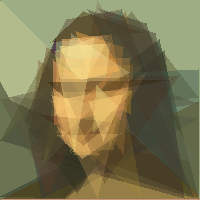

[0:02:28.599344] Iteration     5200  ---  best_fitnesses [0.99532443]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


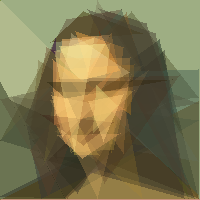

[0:02:31.421944] Iteration     5300  ---  best_fitnesses [0.9953283]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


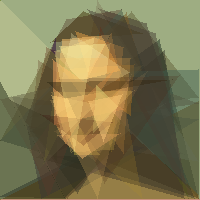

[0:02:34.213051] Iteration     5400  ---  best_fitnesses [0.9953278]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


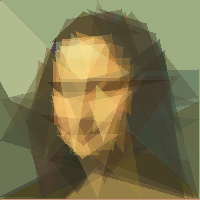

[0:02:36.978137] Iteration     5500  ---  best_fitnesses [0.995331]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


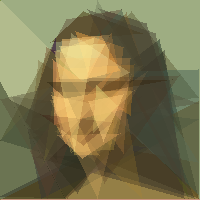

[0:02:39.724233] Iteration     5600  ---  best_fitnesses [0.99533206]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


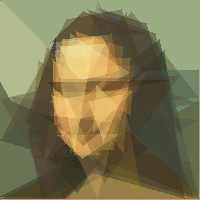

[0:02:42.488979] Iteration     5700  ---  best_fitnesses [0.9953313]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


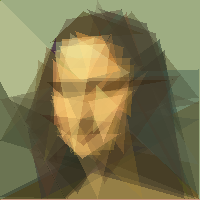

[0:02:45.245470] Iteration     5800  ---  best_fitnesses [0.99533105]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


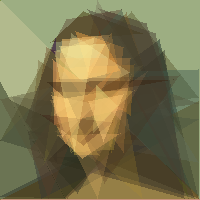

[0:02:48.002090] Iteration     5900  ---  best_fitnesses [0.9953369]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


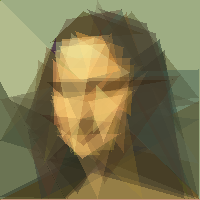

[0:02:50.757738] Iteration     6000  ---  best_fitnesses [0.99533415]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


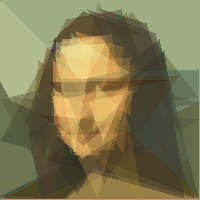

[0:02:53.508413] Iteration     6100  ---  best_fitnesses [0.9953354]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


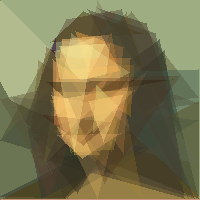

[0:02:56.260367] Iteration     6200  ---  best_fitnesses [0.99533427]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


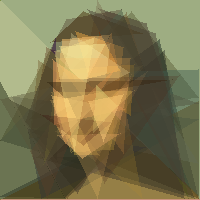

[0:02:58.999313] Iteration     6300  ---  best_fitnesses [0.99533594]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


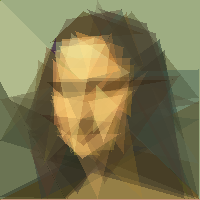

[0:03:01.738464] Iteration     6400  ---  best_fitnesses [0.9953379]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


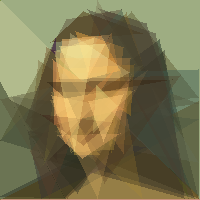

[0:03:04.515557] Iteration     6500  ---  best_fitnesses [0.9953384]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


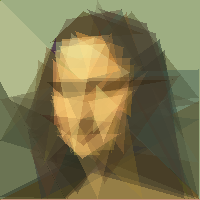

[0:03:07.283123] Iteration     6600  ---  best_fitnesses [0.99533886]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


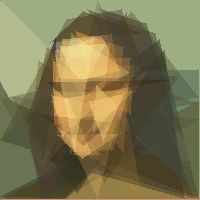

[0:03:10.054483] Iteration     6700  ---  best_fitnesses [0.9953375]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


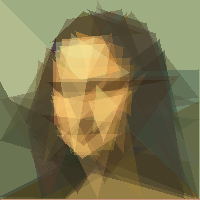

[0:03:12.808981] Iteration     6800  ---  best_fitnesses [0.9953373]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


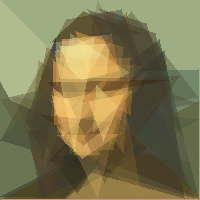

[0:03:15.569905] Iteration     6900  ---  best_fitnesses [0.9953393]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


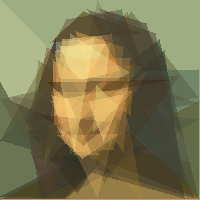

[0:03:18.334634] Iteration     7000  ---  best_fitnesses [0.99533933]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


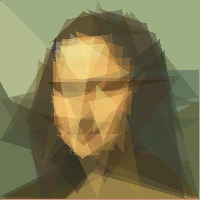

[0:03:21.111403] Iteration     7100  ---  best_fitnesses [0.9953394]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


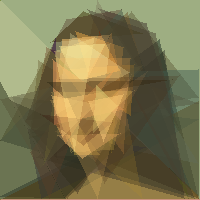

[0:03:23.870708] Iteration     7200  ---  best_fitnesses [0.9953394]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


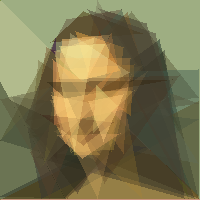

[0:03:26.637811] Iteration     7300  ---  best_fitnesses [0.9953413]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


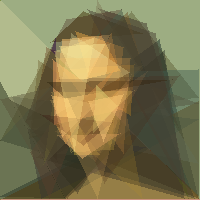

[0:03:29.441693] Iteration     7400  ---  best_fitnesses [0.9953417]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


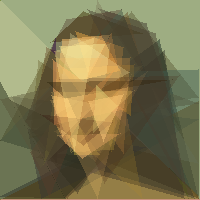

[0:03:32.241498] Iteration     7500  ---  best_fitnesses [0.99534184]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


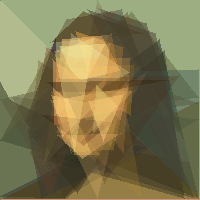

[0:03:35.042553] Iteration     7600  ---  best_fitnesses [0.9953387]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


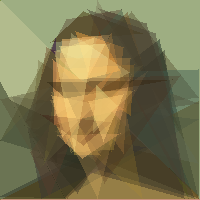

[0:03:37.837257] Iteration     7700  ---  best_fitnesses [0.99534005]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


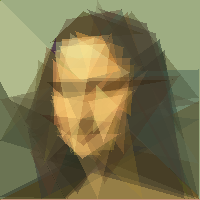

[0:03:40.690686] Iteration     7800  ---  best_fitnesses [0.99534166]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


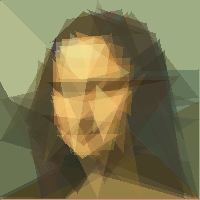

[0:03:43.474127] Iteration     7900  ---  best_fitnesses [0.99534154]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


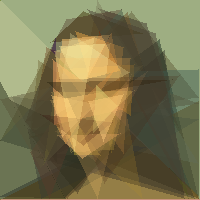

[0:03:46.274369] Iteration     8000  ---  best_fitnesses [0.99534273]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


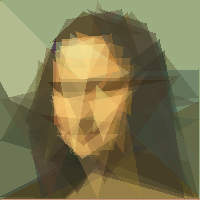

[0:03:49.068636] Iteration     8100  ---  best_fitnesses [0.9953416]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


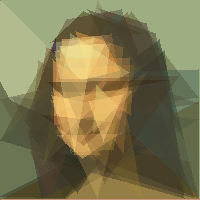

[0:03:51.847705] Iteration     8200  ---  best_fitnesses [0.99534184]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


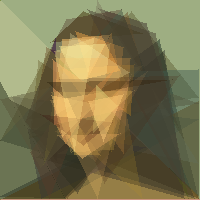

[0:03:54.626768] Iteration     8300  ---  best_fitnesses [0.99534094]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


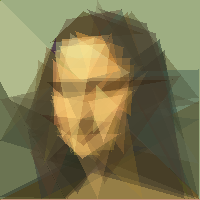

[0:03:57.410370] Iteration     8400  ---  best_fitnesses [0.9953417]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


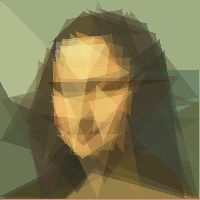

[0:04:00.189457] Iteration     8500  ---  best_fitnesses [0.99534017]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


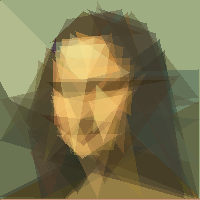

[0:04:02.987110] Iteration     8600  ---  best_fitnesses [0.99533844]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


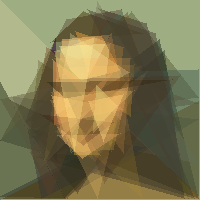

[0:04:05.738455] Iteration     8700  ---  best_fitnesses [0.99534166]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


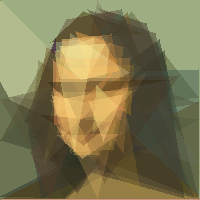

[0:04:08.511242] Iteration     8800  ---  best_fitnesses [0.9953422]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


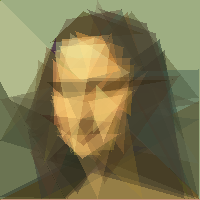

[0:04:11.274729] Iteration     8900  ---  best_fitnesses [0.995342]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


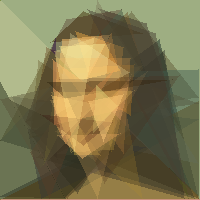

[0:04:14.042587] Iteration     9000  ---  best_fitnesses [0.99534297]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


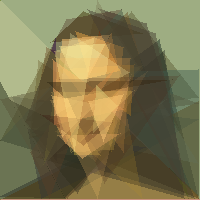

[0:04:16.813441] Iteration     9100  ---  best_fitnesses [0.9953423]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


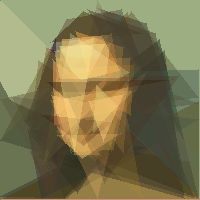

[0:04:19.598281] Iteration     9200  ---  best_fitnesses [0.9953415]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


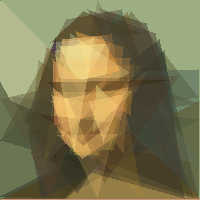

[0:04:22.373066] Iteration     9300  ---  best_fitnesses [0.99534094]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


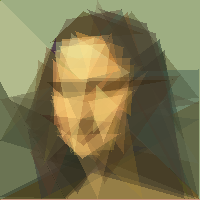

[0:04:25.155720] Iteration     9400  ---  best_fitnesses [0.9953418]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


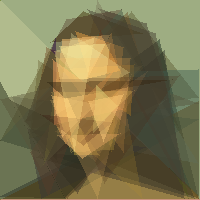

[0:04:27.922963] Iteration     9500  ---  best_fitnesses [0.9953397]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


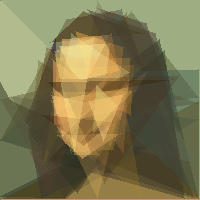

[0:04:30.695848] Iteration     9600  ---  best_fitnesses [0.9953425]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


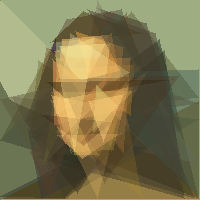

[0:04:33.480100] Iteration     9700  ---  best_fitnesses [0.9953435]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


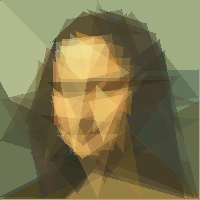

[0:04:36.260153] Iteration     9800  ---  best_fitnesses [0.9953431]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


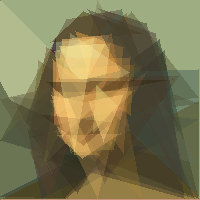

[0:04:39.021252] Iteration     9900  ---  best_fitnesses [0.99534035]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


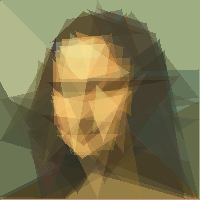

[0:04:41.816184] Iteration    10000  ---  best_fitnesses [0.9953379]
		 best canvas saved to `best_canvas.png` and `best_canvas.svg`


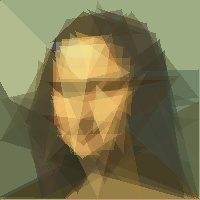

In [ ]:
main_loop()